In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from uproot_io import Events, View
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# Define data sets

SK Learn provides functions to generate data sets for testing purposes, in this case via the make_classification it generates 2D points (features) belonging to two different clusters based. 2D points were chosen here for ease of visualisation, but the number of variables can be extended arbitrarily to suit your needs.

Three data sets are generated from the same underlying distribution, simply using different random seeds. One is the training set for the BDT, the remaining two are validation and test sets. I won't use the validation set here, but if you tune your BDT based on it's performance on a 'test' set, you're effectively turning your test set into a training set, this is the role of the validation set and so final evaluation of the BDT performance should be done using the test set, which should have played no role in training or defining the hyper parameters of the BDT.

In [3]:
# need training features as [[1,2,3,4,5],[1,2,3,4,5],...] and training labels as [6,6,6,6,6,...],
# same format for testing data

In [4]:
events = Events("/Users/mohammed/code/neutrinos-dune-files/PandoraRecoFile_1.root")

In [5]:
# random_numbersold = np.random.randint(0, max(events.event_number), max(events.event_number))
# seventy = int(0.7*len(random_numbersold))
# training = random_numbersold[:seventy]
# testing = random_numbersold[seventy:]
# np.save("training_events", training)
# np.save("testing_events", testing)

In [6]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")

In [8]:
# training data

def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def BDTdata():
    data = []
    label = []
    
    for n in training: 
        
        idx = np.where(events.event_number == n)[0]

        # line of best fit
        gradients = []
        intercepts = []

        xmax = -1000
        xmin = 1000
        zmax = -1000
        zmin = 1000
        for i in idx:
            x0 = events.reco_hits_x_w[i]
            z0 = events.reco_hits_w[i]
            if len(x0) > 0:
                if max(x0) >= xmax:
                    xmax = max(x0)
                if min(x0) <= xmin:
                    xmin = min(x0)
            if len(z0) > 0:
                if max(z0) >= zmax:
                    zmax = max(z0)
                if min(z0) <= zmin:
                    zmin = min(z0)

        xlen = 0.1*(xmax - xmin)
        zlen = 0.1*(zmax - zmin)

        for i in idx:
            
            # features
            entry = []
            
            # hits, pdg code, purity, completeness, adc values, vertex coordinates

            x = events.reco_hits_x_w[i]
            z = events.reco_hits_w[i]
            pdg = events.mc_pdg[i]
            purity = events.purity[i]
            complete = events.completeness[i]

            adc = events.reco_adcs_w[i]
            vx = events.reco_particle_vtx_x[i]
            vz = events.reco_particle_vtx_w[i]
            
            party = []

            # cuts made for clean data
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                party.append(pdg)
                
            for q in range(len(party)):
                if party[q] == 22. or party[q] == -11. or party[q] == 11.:
                    label.append(0) # showers
                else:
                    label.append(1) # tracks
            
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                
                best_inliers = []
                best_model = None
                sample_size = 10
                max_iterations = 100

                for _ in range(max_iterations):
                    sample_size = min(sample_size, len(x))
                    sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                    x_sample = x[sample_indices]
                    z_sample = z[sample_indices]

                    m, c = fit_line(x_sample, z_sample)
                    residuals = calculate_residuals(x, z, m, c)
                    inliers = np.where(residuals < (0.15*xlen))[0]

                    if len(inliers) > len(best_inliers):
                        best_inliers = inliers
                        best_model = (m, c)

                if len(best_inliers) > 0:
                    m, c = best_model

                    gradients.append(m)
                    intercepts.append(c)

                    # changing the coordinates into longitudinal and tranverse from best line

                    znew = z - c
                    angle = -math.atan(m)
                    l = x * np.cos(angle) - znew * np.sin(angle)
                    t = x * np.sin(angle) + znew * np.cos(angle)

                    # feature 1: proximal hits within 5% of transverse range of the hits.

                    tdiff = np.abs(max(t)-min(t))
                    margin = tdiff*0.05
                    inside = [x for x in t if x <= margin and x >= -margin]
                    entry.append(len(inside)/len(t))

                    # feature 2: the standard deviation of the last 30% of a topology

                    p1 = int(0.7 * len(t))
                    X = t[p1:]
                    Xvar = np.var(X)

                    p2 = int(0.3 * len(t))
                    Y = t[:p2]
                    Yvar = np.var(Y)

                    if  Yvar > Xvar:
                        resultY = np.sqrt(Yvar)
                        entry.append(resultY)           
                    else:
                        resultX = np.sqrt(Xvar)
                        entry.append(resultX)

                    # feature 3: the hits per length

                    above = np.sum(t > 0)
                    below = np.sum(t < 0)

                    lmin, lmax = np.min(l), np.max(l)
                    length = lmax - lmin

                    if above == 0 or below == 0 or length == 0:
                        entry.append(2)

                    else:
                        # If symmetric, this should be close to 1, otherwise > 1
                        hits = (above + below) / length
                        entry.append(hits)


                    # feature 4: energy in the last 10% of the track

                    vznew = vz - c

                    vl = vx * np.cos(angle) - vznew * np.sin(angle)
                    vt = vx * np.sin(angle) + vznew * np.cos(angle)

                    if max(l) < vl:
                        l *= -1

                    combined = list(zip(l, t, adc))
                    sort = sorted(combined, key = lambda coord: coord[0])

                    lnew, tnew, adcnew = zip(*sort)

                    percent = int(0.9 * len(adcnew))
                    X = adcnew[percent:]
                    Xsum = np.sum(X)

                    total = np.sum(adcnew)
                    result = Xsum / total

                    entry.append(result)

                    # feature 5: mean connection distance

                    total_distance = 0.0
                    for j in range(len(x) - 1):
                        distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                        total_distance += distance
                    meandist = total_distance/(len(x)-1)
                    entry.append(meandist)
                    data.append(entry)


                else:
                    entry.append(0.1)  # proximal hits
                    entry.append(1.5)  # standard deviation
                    entry.append(2)    # hits per length
                    entry.append(0.25) # energy
                    entry.append(1)    # mean connection distance
                    data.append(entry)
    
    return data, label

In [9]:
data, label = BDTdata()

In [10]:
x_train = data
y_train = label

In [50]:
len(x_train), len(y_train)

(10928, 10928)

In [11]:
# testing

def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def BDTtestData():
    data = []
    label = []
    
    for n in testing: 
        
        idx = np.where(events.event_number == n)[0]

        # line of best fit
        gradients = []
        intercepts = []

        xmax = -1000
        xmin = 1000
        zmax = -1000
        zmin = 1000
        for i in idx:
            x0 = events.reco_hits_x_w[i]
            z0 = events.reco_hits_w[i]
            if len(x0) > 0:
                if max(x0) >= xmax:
                    xmax = max(x0)
                if min(x0) <= xmin:
                    xmin = min(x0)
            if len(z0) > 0:
                if max(z0) >= zmax:
                    zmax = max(z0)
                if min(z0) <= zmin:
                    zmin = min(z0)

        xlen = 0.1*(xmax - xmin)
        zlen = 0.1*(zmax - zmin)

        for i in idx:
            
            # features
            entry = []
            
            # hits, pdg code, purity, completeness, adc values, vertex coordinates

            x = events.reco_hits_x_w[i]
            z = events.reco_hits_w[i]
            pdg = events.mc_pdg[i]
            purity = events.purity[i]
            complete = events.completeness[i]

            adc = events.reco_adcs_w[i]
            vx = events.reco_particle_vtx_x[i]
            vz = events.reco_particle_vtx_w[i]
            
            party = []

            # cuts made for clean data
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                party.append(pdg)
                
            for q in range(len(party)):
                if party[q] == 22. or party[q] == -11. or party[q] == 11.:
                    label.append(0) # showers
                else:
                    label.append(1) # tracks
            
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                
                best_inliers = []
                best_model = None
                sample_size = 10
                max_iterations = 100

                for _ in range(max_iterations):
                    sample_size = min(sample_size, len(x))
                    sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                    x_sample = x[sample_indices]
                    z_sample = z[sample_indices]

                    m, c = fit_line(x_sample, z_sample)
                    residuals = calculate_residuals(x, z, m, c)
                    inliers = np.where(residuals < (0.15*xlen))[0]

                    if len(inliers) > len(best_inliers):
                        best_inliers = inliers
                        best_model = (m, c)

                if len(best_inliers) > 0:
                    m, c = best_model

                    gradients.append(m)
                    intercepts.append(c)

                    # changing the coordinates into longitudinal and tranverse from best line

                    znew = z - c
                    angle = -math.atan(m)
                    l = x * np.cos(angle) - znew * np.sin(angle)
                    t = x * np.sin(angle) + znew * np.cos(angle)

                    # feature 1: proximal hits within 5% of transverse range of the hits.

                    tdiff = np.abs(max(t)-min(t))
                    margin = tdiff*0.05
                    inside = [x for x in t if x <= margin and x >= -margin]
                    entry.append(len(inside)/len(t))

                    # feature 2: the standard deviation of the last 30% of a topology

                    p1 = int(0.7 * len(t))
                    X = t[p1:]
                    Xvar = np.var(X)

                    p2 = int(0.3 * len(t))
                    Y = t[:p2]
                    Yvar = np.var(Y)

                    if  Yvar > Xvar:
                        resultY = np.sqrt(Yvar)
                        entry.append(resultY)           
                    else:
                        resultX = np.sqrt(Xvar)
                        entry.append(resultX)

                    # feature 3: the hits per length

                    above = np.sum(t > 0)
                    below = np.sum(t < 0)

                    lmin, lmax = np.min(l), np.max(l)
                    length = lmax - lmin

                    if above == 0 or below == 0 or length == 0:
                        entry.append(2)

                    else:
                        # If symmetric, this should be close to 1, otherwise > 1
                        hits = (above + below) / length
                        entry.append(hits)


                    # feature 4: energy in the last 10% of the track

                    vznew = vz - c

                    vl = vx * np.cos(angle) - vznew * np.sin(angle)
                    vt = vx * np.sin(angle) + vznew * np.cos(angle)

                    if max(l) < vl:
                        l *= -1

                    combined = list(zip(l, t, adc))
                    sort = sorted(combined, key = lambda coord: coord[0])

                    lnew, tnew, adcnew = zip(*sort)

                    percent = int(0.9 * len(adcnew))
                    X = adcnew[percent:]
                    Xsum = np.sum(X)

                    total = np.sum(adcnew)
                    result = Xsum / total

                    entry.append(result)

                    # feature 5: mean connection distance

                    total_distance = 0.0
                    for j in range(len(x) - 1):
                        distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                        total_distance += distance
                    meandist = total_distance/(len(x)-1)
                    entry.append(meandist)
                    data.append(entry)


                else:
                    entry.append(0.1)  # proximal hits
                    entry.append(1.5)  # standard deviation
                    entry.append(2)    # hits per length
                    entry.append(0.25) # energy
                    entry.append(1)    # mean connection distance
                    data.append(entry)
    
    return data, label

In [12]:
x_test, y_test = BDTtestData()

In [13]:
len(x_test), len(y_test)

(4739, 4739)

In [14]:
np.save("x_train", x_train)
np.save("y_train", y_train)
np.save("x_test", x_test)
np.save("y_test", y_test)

# Creating and training the BDT

Now we can create the BDT itself. The BDT (AdaBoostClassifier) will be composed of many base trees (DecisionTreeClassifier). This is essentially the default set up for a BDT, you can find details of the arguments used here and many other hyper-parameters (essentially the parameters that describe the structure of the tree, rather than physics variables) via the SK learn documentation. Note comparing the performance of your BDT for different values of max-depth, for example, is the sort of task you would perform (after training) with the validation set, and once you've settled on a 'best' set of hyper-parameters, then you would perform a final evaluation of that tree using the test set.

Having defined the tree in these first two, the next step is to train the BDT by simply calling the fit function and supplying the training features (x_train) and labels (y_train).

In [15]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [19]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
base = DecisionTreeClassifier(max_depth=6)
bdt = AdaBoostClassifier(estimator=base, n_estimators=100, random_state=0)
# Fit the BDT to the training set
bdt.fit(x_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=6),
                   n_estimators=100, random_state=0)

# Checking the classification performance

Once trained, we can evaluate the performance of the BDT. First you can see how well the BDT was actually able to fit the training data - if there's no predictive power in your features, or insufficient degrees of freedom in your BDT, no amount of training will yield anything useful. In this case we can see that the classification accuracy for this default BDT is pretty good, classifiying about 92% of points correctly

In [20]:
# Check the training set classification performance
bdt.score(x_train, y_train)

1.0

In [21]:
# finding the best tree depth

param_grid = {'max_depth': range(1, 21)}
grid_search = GridSearchCV(base, param_grid, cv=5, scoring='accuracy')  
grid_search.fit(x_train, y_train)
best_depth = grid_search.best_params_['max_depth']
best_score = grid_search.best_score_
print("Best Depth:", best_depth)
print("Best Score:", best_score)

Best Depth: 10
Best Score: 0.9657762629255027


In [22]:
y_train = np.array(y_train)

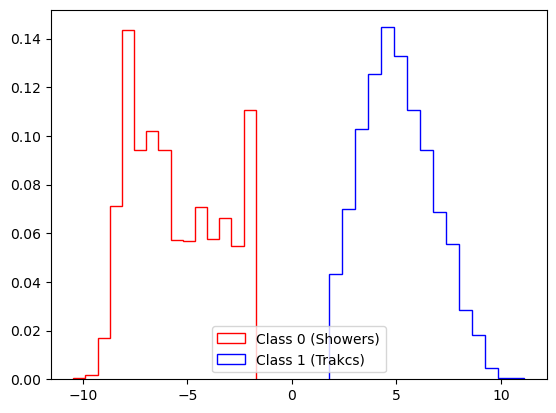

In [23]:
f = bdt.decision_function(x_train)
min_f = np.round(np.min(f), 1)
max_f = np.round(np.max(f), 1)
bins = 15
# bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
cls_0_f = f[np.where(y_train == 0)]
cls_1_f = f[np.where(y_train == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Showers)')
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Trakcs)')
plt.legend()

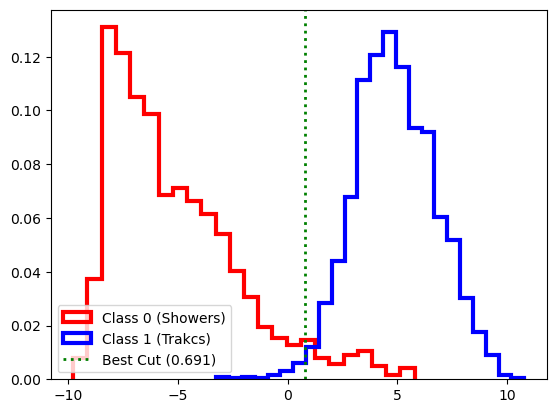

In [49]:
f = bdt.decision_function(x_test)
min_f = np.round(np.min(f), 1)
max_f = np.round(np.max(f), 1)
bins = 24
# bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
cls_0_f = f[np.where(y_test == 0)]
cls_1_f = f[np.where(y_test == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Showers)', linewidth=3)
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Trakcs)', linewidth=3)
plt.axvline(x=0.7967273969577816, color='green', linestyle='dotted', linewidth=2, label='Best Cut (0.691)')
plt.legend()

If you're happy with your training sample performance, you can move on to evaluating on a sample your BDT hasn't seen before. I'm not going to do any tuning, so I'll move straight to the test set. We can see that the classification performance is about 85%, which is not bad, but may indicate overfitting. This may be due to an insufficiently large training set (and thereby potentially unrepresenative of the underlying distribution), or it could be that the BDT has too many degrees of freedom and is therefore learning how to predict the specific case seen in the training set, rather than the more general case.

This is where you may want to review sample size, or hyper-parameters of your tree.

In [25]:
# Check the test set classification performance
bdt.score(x_test, y_test)

0.9761553070267989

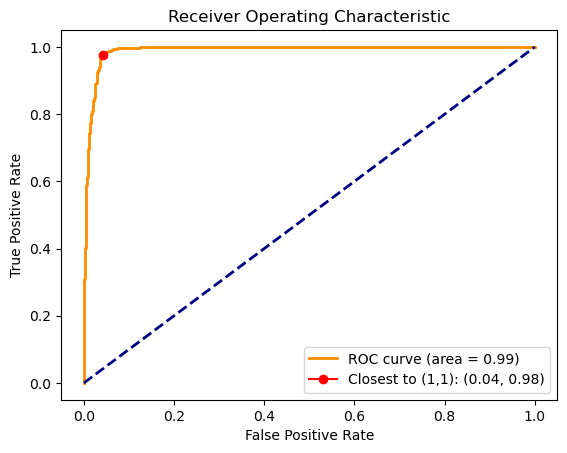

Best Cut: 0.7967273969577816
AUC: 0.9901601440821205


In [26]:
y_probs = bdt.predict_proba(x_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

closest_point = np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))
fpr_rounded = round(fpr[closest_point], 2)
tpr_rounded = round(tpr[closest_point], 2)

optimal_threshold = thresholds[closest_point]

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr[closest_point], tpr[closest_point], marker='o', color='red', label=f'Closest to (1,1): {fpr_rounded, tpr_rounded}')

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'Best Cut: {optimal_threshold}')
print(f'AUC: {roc_auc}')

In [27]:
# applying the best cut
scores = bdt.decision_function(x_test)
predictions = (scores > optimal_threshold).astype(int)

In [28]:
bdt.score(x_test, predictions)

0.9913483857353872

In [39]:
cm = confusion_matrix(y_test, predictions)
cm

array([[1169,   68],
       [  46, 3456]])

In [40]:
TTAT = cm[1][1]
TTAS = cm[1][0]
TSAT = cm[0][1]
TSAS = cm[0][0]

In [41]:
TTATprob = TTAT/(TTAT+TTAS)
TTASprob = TTAS/(TTAT+TTAS)
TSATprob = TSAT/(TSAT+TSAS)
TSASprob = TSAS/(TSAT+TSAS)

In [42]:
confusion = np.array(([TSASprob, TSATprob],[TTASprob, TTATprob]))
print(confusion)

[[0.94502829 0.05497171]
 [0.01313535 0.98686465]]


In [43]:
e4 = np.sqrt((TTATprob*(1-TTATprob))/TTAT)
e3 = np.sqrt((TTASprob*(1-TTASprob))/TTAS)
e2 = np.sqrt((TSATprob*(1-TSATprob))/TSAT)
e1 = np.sqrt((TSASprob*(1-TSASprob))/TSAS)

In [44]:
error = np.array(([e1, e2],[e3, e4]))
print(error)

[[0.0066663  0.02763997]
 [0.01678691 0.0019367 ]]


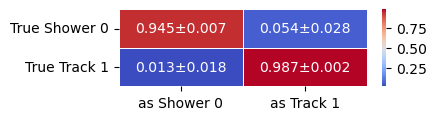

In [45]:
variable_names1 = ['as Shower 0', 'as Track 1']
variable_names2 = ['True Shower 0', 'True Track 1']

annot_arr = np.array([['0.945±0.007','0.054±0.028'],
                      ['0.013±0.018','0.987±0.002']], dtype = str)

plt.figure(figsize = (4,1))
heatmap = sns.heatmap(confusion, annot=annot_arr, cmap='coolwarm', fmt="s", linewidths=.5, square=False)
heatmap.set_xticklabels(variable_names1, rotation=0)
heatmap.set_yticklabels(variable_names2, rotation=0)
#plt.title("Confusion Matrix")±±±±±
plt.show()